# 05: EDA - Explore Night lights and Population

As I was working on the data preparation in the last notebook, I realized it will probably be pretty hard to tell the population change from satellite imagery since buildings usually stay for a while even if people are not living there anymore.

I will explore in this notebook if there is a correlation between change in night lights and the population to see if I can use this data to explore population decline.

Use census data and VIIRS Nighttime data from 2015 to 2020.



In [1]:
import ee
import time

import rioxarray
import xarray as xr

In [10]:
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

### Get 2015 and 2020 images, export

In [73]:
i_date = '2015-01-01'
f_date = '2015-12-31'

# Get median image for year
night_light_2015 = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate(i_date, f_date).select('avg_rad').median()

# census data
census_2015 = ee.ImageCollection("CIESIN/GPWv411/GPW_Population_Count").filterDate(i_date, f_date).first()


i_date2 = '2020-01-01'
f_date2 = '2020-12-31'

# Get median image for year
night_light_2020 = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate(i_date2, f_date2).select('avg_rad').median()

# census data
census_2020 = ee.ImageCollection("CIESIN/GPWv411/GPW_Population_Count").filterDate(i_date2, f_date2).first()

# NO2 data

no2_2020 = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2").filterDate(i_date, f_date).select('tropospheric_NO2_column_number_density').median()

In [84]:
no2_2020

I learned that instead of scale, I should use the `crs` and `crsTransform` to align.

Definition: The crsTransform parameter is a list of parameters from an affine transformation matrix in row-major order [xScale, xShearing, xTranslation, yShearing, yScale, yTranslation]. An image's origin is defined by the xTranslation and yTranslation values, and the image's pixel size is defined by the xScale and yScale values.

https://developers.google.com/earth-engine/guides/exporting

In [12]:
print(census_2015.projection().getInfo())

{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [0.00833333333333333, 0, -180, 0, -0.00833333333333333, 89.99999999999991]}


In [13]:
print(night_light_2015.projection().getInfo())

{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}


In [14]:
# Define regions

# Kanazawa to Yokohama
region1 = ee.Geometry.BBox(135.9259, 35.4698, 140.8698 , 36.6422)

# Kyushu
region2 = ee.Geometry.BBox(129.542275, 31.629761 ,131.981586 , 33.760804)

# Hiroshima/Osaka
region3 = ee.Geometry.BBox(130.987217, 33.760804, 136.611616, 35.448746)

# Shikoku
region4 = ee.Geometry.BBox(131.981586, 32.811406, 136.611616, 33.760804)

# Nagoya to Yokohama
region5 = ee.Geometry.BBox(136.6950, 34.4071, 140.6061, 35.4519)

# North of Tokyo to Niigata
region6 = ee.Geometry.BBox(136.5728, 36.6422, 141.0772, 38.3578)

# Sendai/Fukushima
region7 = ee.Geometry.BBox(139.5172, 38.3578, 142.0440, 41.5075)

# Hokkaido
region8 = ee.Geometry.BBox(139.4293, 41.5075, 145.6695, 45.5669)

all_regions = [region1, region2, region3, region4, region5, region6, region7, region8]


In [15]:
census_2015.clip(region2).projection().getInfo()

{'type': 'Projection',
 'crs': 'EPSG:4326',
 'transform': [0.00833333333333333,
  0,
  -180,
  0,
  -0.00833333333333333,
  89.99999999999991]}

In [16]:
images_nightlights = [night_light_2015, night_light_2020]
years = [2015, 2020]
crs = census_2015.projection().getInfo()['crs']
transform = census_2015.projection().getInfo()['transform']

In [18]:
for i, region in enumerate(all_regions):
    for j, image in enumerate(images_nightlights):
        print(f'Processing: Region {i}, Year {years[j]}')
        task = ee.batch.Export.image.toDrive(image = image,
                                             fileNamePrefix = f'nightlights_{years[j]}_region{i}',
                                             region = region,
                                             folder = 'NightLightImages0902',
                                             crsTransform=transform,
                                             crs = crs)

        task.start()

        status = task.status()['state']

        while status != 'COMPLETED':
            print(f'Status: {status}')

            if status == 'FAILED':
                print(task.status())
                break

            time.sleep(10)
            status = task.status()['state']

images_census = [census_2015, census_2020]
years = [2015, 2020]

for i, region in enumerate(all_regions):
    for j, image in enumerate(images_census):
        print(f'Processing: Region {i}, Year {years[j]}')
        task = ee.batch.Export.image.toDrive(image = image,
                                             fileNamePrefix = f'census_{years[j]}_region{i}',
                                             region = region,
                                             folder = 'NightLightImages0902',
                                             crs = crs,
                                             crsTransform = transform)

        task.start()
        status = task.status()['state']
        while status != 'COMPLETED':
            print(f'Status: {status}')

            if status == 'FAILED':
                print(task.status())
                break

            time.sleep(10)
            status = task.status()['state']

Processing: Region 0, Year 2015
Status: READY
Status: READY
Status: READY
Status: READY
Status: RUNNING
Processing: Region 0, Year 2020
Status: READY
Status: READY
Status: READY
Status: READY
Status: RUNNING
Processing: Region 1, Year 2015
Status: READY
Status: RUNNING
Processing: Region 1, Year 2020
Status: READY
Status: READY
Status: RUNNING
Processing: Region 2, Year 2015
Status: READY
Status: RUNNING
Processing: Region 2, Year 2020
Status: READY
Status: RUNNING
Processing: Region 3, Year 2015
Status: READY
Status: RUNNING
Processing: Region 3, Year 2020
Status: READY
Status: RUNNING
Processing: Region 4, Year 2015
Status: READY
Status: RUNNING
Processing: Region 4, Year 2020
Status: READY
Status: READY
Processing: Region 5, Year 2015
Status: READY
Status: RUNNING
Processing: Region 5, Year 2020
Status: READY
Status: RUNNING
Processing: Region 6, Year 2015
Status: READY
Status: RUNNING
Processing: Region 6, Year 2020
Status: READY
Status: RUNNING
Processing: Region 7, Year 2015
Stat

In [86]:
task = ee.batch.Export.image.toDrive(image = no2_2020,
                                             fileNamePrefix = f'n02_{years[0]}_region{0}',
                                             region = region1,
                                             crsTransform=transform,
                                             crs = crs)
task.start()

In [85]:
transform

[0.00833333333333333, 0, -180, 0, -0.00833333333333333, 89.99999999999991]

In [102]:
task = ee.batch.Export.image.toDrive(image = night_light_2015,
                                             fileNamePrefix = f'nightlights_{years[0]}_region{0}',
                                             region = region1,
                                             crsTransform=transform,
                                             crs = crs)
task.start()

In [88]:
task.status()

{'state': 'FAILED',
 'description': 'myExportImageTask',
 'creation_timestamp_ms': 1662166789481,
 'update_timestamp_ms': 1662166795139,
 'start_timestamp_ms': 1662166794905,
 'task_type': 'EXPORT_IMAGE',
 'attempt': 1,
 'error_message': "Can't get band number 0. Image has no bands.",
 'id': 'CC5CVR7UWFFXURRBEVDBNGSB',
 'name': 'projects/earthengine-legacy/operations/CC5CVR7UWFFXURRBEVDBNGSB'}

## Load Images

In [49]:
# test image
census_2015_r0 = rioxarray.open_rasterio('../data/NightLightImages0902/census_2015_region0.tif')
lights_2015_r0 = rioxarray.open_rasterio('../data/NightLightImages0902/nightlights_2015_region0.tif')
census_2020_r0 = rioxarray.open_rasterio('../data/NightLightImages0902/census_2020_region0.tif')
lights_2020_r0 = rioxarray.open_rasterio('../data/NightLightImages0902/nightlights_2020_region0.tif')

In [20]:
census_2015_r0

<xarray.DataArray (band: 1, y: 142, x: 594)>
array([[[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [73.24027, 73.24027, ...,      nan,      nan],
        [73.24788, 73.24789, ...,      nan,      nan]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 135.9 135.9 135.9 136.0 ... 140.8 140.9 140.9 140.9
  * y            (y) float64 36.65 36.64 36.63 36.62 ... 35.5 35.49 35.48 35.47
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     population_count

In [21]:
lights_2015_r0

<xarray.DataArray (band: 1, y: 142, x: 594)>
array([[[0.04382 , 0.032853, ..., 0.094123, 0.09376 ],
        [0.020604, 0.024438, ..., 0.089975, 0.118875],
        ...,
        [0.197199, 0.159668, ..., 0.077973, 0.056789],
        [0.148609, 0.154095, ..., 0.0418  , 0.036489]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 135.9 135.9 135.9 136.0 ... 140.8 140.9 140.9 140.9
  * y            (y) float64 36.65 36.64 36.63 36.62 ... 35.5 35.49 35.48 35.47
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     avg_rad

In [22]:
census_2015_r0.x

<xarray.DataArray 'x' (x: 594)>
array([135.929167, 135.9375  , 135.945833, ..., 140.854167, 140.8625  ,
       140.870833])
Coordinates:
  * x            (x) float64 135.9 135.9 135.9 136.0 ... 140.8 140.9 140.9 140.9
    spatial_ref  int64 0

In [23]:
lights_2015_r0.x

<xarray.DataArray 'x' (x: 594)>
array([135.929167, 135.9375  , 135.945833, ..., 140.854167, 140.8625  ,
       140.870833])
Coordinates:
  * x            (x) float64 135.9 135.9 135.9 136.0 ... 140.8 140.9 140.9 140.9
    spatial_ref  int64 0

In [24]:
lights_2015_r0.rio.resolution()

(0.00833333333333333, -0.00833333333333333)

In [25]:
census_2015_r0.rio.resolution()

(0.00833333333333333, -0.00833333333333333)

In [34]:
census_df = census_2015_r0.to_dataframe(name = 'census_df').reset_index()
lights_df = lights_2015_r0.to_dataframe(name = 'lights').reset_index()

In [35]:
census_df.head()

,band,y,x,spatial_ref,census_df
0,1,36.645833,135.929167,0,NaN
1,1,36.645833,135.937500,0,NaN
2,1,36.645833,135.945833,0,NaN
3,1,36.645833,135.954167,0,NaN
4,1,36.645833,135.962500,0,NaN


In [36]:
lights_df.head()

,band,y,x,spatial_ref,lights
0,1,36.645833,135.929167,0,0.043820
1,1,36.645833,135.937500,0,0.032853
2,1,36.645833,135.945833,0,0.041346
3,1,36.645833,135.954167,0,0.022220
4,1,36.645833,135.962500,0,0.032653


In [37]:
census_df.describe()

,band,y,x,spatial_ref,census_df
count,84348.0,84348.000000,84348.000000,84348.0,75980.000000
mean,1.0,36.058333,138.400000,0.0,561.045166
std,0.0,0.341592,1.428948,0.0,1499.795410
min,1.0,35.470833,135.929167,0.0,0.000000
25%,1.0,35.762500,137.162500,0.0,36.087353
50%,1.0,36.058333,138.400000,0.0,151.653732
75%,1.0,36.354167,139.637500,0.0,345.177002
max,1.0,36.645833,140.870833,0.0,15934.238281


In [38]:
lights_df.describe()

,band,y,x,spatial_ref,lights
count,84348.0,84348.000000,84348.000000,84348.0,84348.000000
mean,1.0,36.058333,138.400000,0.0,2.690644
std,0.0,0.341592,1.428948,0.0,7.294168
min,1.0,35.470833,135.929167,0.0,0.006251
25%,1.0,35.762500,137.162500,0.0,0.140830
50%,1.0,36.058333,138.400000,0.0,0.315988
75%,1.0,36.354167,139.637500,0.0,1.604378
max,1.0,36.645833,140.870833,0.0,217.520508


In [43]:
census_with_lights = census_df.merge(lights_df, on = ['y', 'x', 'band']).dropna().reset_index()

In [44]:
census_with_lights.head()

,index,band,y,x,spatial_ref_x,census_df,spatial_ref_y,lights
0,83,1,36.645833,136.620833,0,39.181091,0,0.870313
1,84,1,36.645833,136.629167,0,761.420959,0,1.538221
2,85,1,36.645833,136.637500,0,993.808655,0,4.787305
3,86,1,36.645833,136.645833,0,975.235657,0,10.247175
4,87,1,36.645833,136.654167,0,573.612671,0,4.864187


<AxesSubplot:xlabel='census_df', ylabel='lights'>

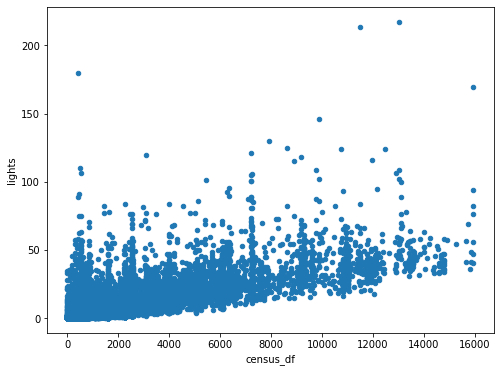

In [48]:
census_with_lights.plot(x = 'census_df', y = 'lights', kind = 'scatter', figsize = (8, 6))

There's a lot of noise in here, but it's cool to see there seems to be some correlation with lighting level and population. What about change?

In [50]:
census_2020_df = census_2020_r0.to_dataframe(name = 'pop_2020').reset_index()
lights_2020_df = lights_2020_r0.to_dataframe(name = 'lights_2020').reset_index()

In [53]:
merged_2020 = census_2020_df.merge(lights_2020_df, on = ['band', 'x', 'y']).dropna().reset_index()

In [54]:
merged_2020.head()

,index,band,y,x,spatial_ref_x,pop_2020,spatial_ref_y,lights_2020
0,83,1,36.645833,136.620833,0,39.047592,0,0.75375
1,84,1,36.645833,136.629167,0,758.826721,0,1.24875
2,85,1,36.645833,136.637500,0,990.422546,0,3.57625
3,86,1,36.645833,136.645833,0,971.912903,0,6.13375
4,87,1,36.645833,136.654167,0,571.658264,0,4.16125


In [55]:
# merge the 2015 and 2020 datasets

df_2015 = census_with_lights[['x', 'y', 'census_df', 'lights']]
df_2020 = merged_2020[['x', 'y', 'pop_2020', 'lights_2020']]

change_pop = df_2015.merge(df_2020, on = ['x', 'y']).dropna().reset_index()

change_pop.head()

,index,x,y,census_df,lights,pop_2020,lights_2020
0,0,136.620833,36.645833,39.181091,0.870313,39.047592,0.75375
1,1,136.629167,36.645833,761.420959,1.538221,758.826721,1.24875
2,2,136.637500,36.645833,993.808655,4.787305,990.422546,3.57625
3,3,136.645833,36.645833,975.235657,10.247175,971.912903,6.13375
4,4,136.654167,36.645833,573.612671,4.864187,571.658264,4.16125


In [63]:
change_pop['change_in_pop'] = change_pop['pop_2020'] - change_pop['census_df']
change_pop['change_in_lights'] = change_pop['lights_2020'] - change_pop['lights']
change_pop['change_in_pop_per'] = change_pop['change_in_pop'] / change_pop['census_df'] * 100
change_pop['change_in_lights_per'] = change_pop['change_in_lights'] / change_pop['lights'] * 100

In [64]:
change_pop.head()

,index,x,y,census_df,lights,pop_2020,lights_2020,change_in_pop,change_in_lights,change_in_pop_per,change_in_lights_per
0,0,136.620833,36.645833,39.181091,0.870313,39.047592,0.75375,-0.133499,-0.116563,-0.340723,-13.393225
1,1,136.629167,36.645833,761.420959,1.538221,758.826721,1.24875,-2.594238,-0.289471,-0.340710,-18.818579
2,2,136.637500,36.645833,993.808655,4.787305,990.422546,3.57625,-3.386108,-1.211055,-0.340720,-25.297216
3,3,136.645833,36.645833,975.235657,10.247175,971.912903,6.13375,-3.322754,-4.113425,-0.340713,-40.142040
4,4,136.654167,36.645833,573.612671,4.864187,571.658264,4.16125,-1.954407,-0.702937,-0.340719,-14.451276


In [67]:
change_pop.describe()

,index,x,y,census_df,lights,pop_2020,lights_2020,change_in_pop,change_in_lights,change_in_pop_per,change_in_lights_per
count,75980.000000,75980.000000,75980.000000,75980.000000,75980.000000,75980.000000,75980.000000,75980.000000,75980.000000,75649.000000,75980.000000
mean,37989.500000,138.375899,36.047960,561.045105,2.942849,573.533386,3.116566,12.488246,0.173717,-0.556942,78.540436
std,21933.681064,1.306132,0.335893,1499.795410,7.632520,1559.890503,7.882037,62.571674,1.359559,1.783999,86.051445
min,0.000000,135.929167,35.470833,0.000000,0.017916,0.000000,0.232500,-32.393066,-114.507751,-2.485887,-86.416664
25%,18994.750000,137.262500,35.762500,36.087353,0.151319,35.383270,0.353750,-2.081116,0.127287,-2.003637,8.826560
50%,37989.500000,138.370833,36.037500,151.653732,0.376016,150.358307,0.568750,-0.581619,0.195765,-1.233979,54.420284
75%,56984.250000,139.487500,36.337500,345.177017,1.843156,343.561745,1.935000,-0.207652,0.236514,-0.168068,132.570038
max,75979.000000,140.870833,36.645833,15934.238281,217.520508,16671.593750,246.217499,737.355469,46.866074,4.627505,1525.646851


<AxesSubplot:xlabel='change_in_pop', ylabel='change_in_lights'>

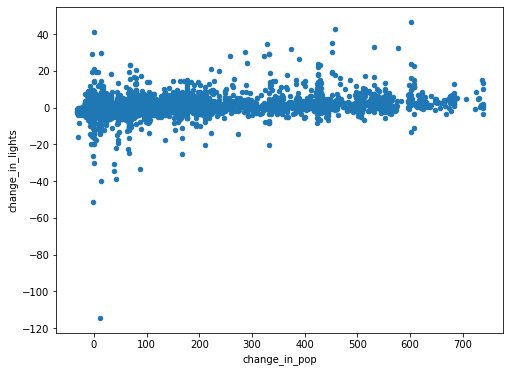

In [65]:
change_pop.plot(x = 'change_in_pop', y = 'change_in_lights', kind = 'scatter', figsize = (8, 6))

<AxesSubplot:xlabel='change_in_pop_per', ylabel='change_in_lights_per'>

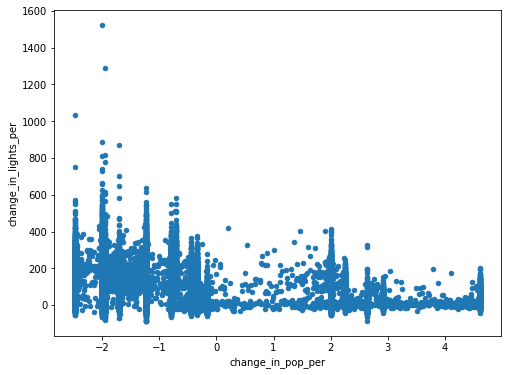

In [66]:
change_pop.plot(x = 'change_in_pop_per', y = 'change_in_lights_per', kind = 'scatter', figsize = (8, 6))